In [1]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.api import VAR 

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from keras.models import Model, Sequential
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'

In [2]:
os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'
def retrieve_data(path):

    columns = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]',
       'Waste  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'Time']

    # creo il vettore degli anni e il df vuoto dove appendere i singoli df
    years = [2016, 2017, 2018, 2019, 2020, 2021] # , 2022
    tot = pd.DataFrame()
    
    # carico i dati dei diversi anni
    for year in years:
        df = pd.read_csv(os.path.join(path, f"ITA{year}.csv"), parse_dates = ['MTU'])
        #df = df.reset_index()
        
        # aggiusto il formato della data in YYYY-MM-DD HH:mm:ss
        for i, row in df.iterrows():
            df["MTU"][i] = df['MTU'][i][:16]
        
        #df = df.drop_duplicates()
        
        df['Time'] = pd.to_datetime(df['MTU'], utc=True, infer_datetime_format=True)

        df.Time = df.Time.dt.strftime('%Y-%m-%d %H:%M:%S')

        df['Time'] = df['Time'].drop_duplicates()

        df = df[columns].sort_values(by=['Time'])
        
        # appendo i vari df a quello vuoto principale
        tot = pd.concat([tot, df], ignore_index=True)
    
    # imposto la data come indice
    tot = tot.set_index(pd.DatetimeIndex(tot['Time']))

    #tot.sort_index
    
    return tot
data = retrieve_data(path)
print('There are {} missing values or NaNs in df_final.'.format(data.isnull().values.sum()))

data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)
def data_and_aggregator(df):

    # seleziono tutte le colonne delle fonti energetiche
    columns = df.columns[ : df.shape[1]-1]

    # aggrego giornalmente i dati
    #daily_df = pd.DataFrame(df[columns].groupby([pd.Grouper(level='Time', freq='D')]).sum())

    # creo l'aggregato totale
    df['total_aggregated'] = df[columns].sum(axis=1)

    # aggrego i dati dell'idroelettrico
    hydro_cols = ['Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]']
    
    df['hydro_tot'] = df[hydro_cols].sum(axis=1)

    # aggrego i dati del gas
    gas_cols = ['Fossil Coal-derived gas  - Actual Aggregated [MW]',
                'Fossil Gas  - Actual Aggregated [MW]']
    
    df['gas_tot'] = df[gas_cols].sum(axis=1)

    df = df.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'hard_coal', 
                            'Fossil Oil  - Actual Aggregated [MW]': 'oil',
                            'Geothermal  - Actual Aggregated [MW]': 'geothermal',
                            'Waste  - Actual Aggregated [MW]': 'waste',
                            'Other  - Actual Aggregated [MW]': 'other',
                            'Solar  - Actual Aggregated [MW]' : 'solar',
                            'Wind Onshore  - Actual Aggregated [MW]' : 'wind',
                            'Biomass  - Actual Aggregated [MW]' : 'biomass'})
    
    df = df.drop(df[hydro_cols], axis = 1)
    df = df.drop(df[gas_cols], axis = 1)

    return df
data = data_and_aggregator(data)
# creo due dunzioni: una per i weekend (quando sabato/domenica è 1, altrimenti 0) e l'altra per le vacanze (1/1, 25/4, 1/5, 2/6, 15/8, 25/12)
def businesshour_and_we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        hour = position.hour
        weekend = position.weekday()
        df.loc[position, 'weekend'] = weekend
        df.loc[position, 'hour'] = hour
        
        if (weekend == 5):
            df.loc[position, 'saturday'] = 1
            df.loc[position, 'weekend'] = 1
        elif (weekend == 6):
            df.loc[position, 'sunday'] = 1
            df.loc[position, 'weekend'] = 2
        else:
            df.loc[position, 'saturday'] = 0
            df.loc[position, 'sunday'] = 0
            df.loc[position, 'weekend'] = 0
            
        if (hour >= 8 and hour <= 18):
            df.loc[position, 'business hour'] = 1
        else:
            df.loc[position, 'business hour'] = 0

    df.saturday = df.saturday.fillna(0)
    df.sunday = df.sunday.fillna(0)

    return df

data = businesshour_and_we_generation(data)
data = data.dropna()

C:\Users\loren\AppData\Local\Temp\ipykernel_37128\1175379662.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_37128\1175379662.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_37128\1175379662.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16

There are 2245 missing values or NaNs in df_final.


In [49]:
def plot_model_rmse_and_loss(history):
    
    #evaluating train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    #val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    #val_loss = history.history['val_loss']
    
    #visualizing epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    #plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs / Training RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    #plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs / Training Loss')

    plt.show()

def plot_preds_vs_actual(true, preds):
    plt.figure(figsize=(12,6))
    plt.plot(true, label='Real')
    plt.plot(preds, label='Predicted')
    plt.title('Predicted vs Real Values')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Total Aggregated')
    plt.legend()
    plt.show()



In [124]:
n_train = 35064

features = ['total_aggregated']
feature_array = data[features].values

# Initialize the scaler
scaler = StandardScaler()

scaler.fit(feature_array[:n_train].reshape(-1,1))
scaled_array = scaler.transform(feature_array)

# Create a DataFrame from the observations
df = pd.DataFrame(scaled_array, columns=['total_aggregated'])


# Create 24 lags and store them as new columns in the DataFrame
for i in range(1, 25):
    df[f'lag_{i}'] = df['total_aggregated'].shift(i)

# Interpolate missing values
df = df.bfill()
# Define the number of train and test observations

# Separate the lags (features) and the observation (target)
X = df.drop('total_aggregated', axis=1)
y = df['total_aggregated']

# Separate the features into training and test sets
X_train = X[:n_train]
X_test = X[n_train:]

y_train, y_test = y[:n_train], y[n_train:]

In [ ]:
## Fit the scaler on the training data and transform it
#X_train_scaled = scaler.fit_transform(X_train)
#
## Use the fitted scaler to transform the test data
#X_test_scaled = scaler.transform(X_test)
#
## Separate the target into training and test sets
#y_train, y_test = y[:n_train], y[n_train:]
#
## Fit the scaler on the training data and transform it
#y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
#
## Use the fitted scaler to transform the test data
#y_test_scaled = scaler.transform(y_test.values.reshape(-1,1))

In [125]:
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

In [126]:
# Define the model
mlp = tf.keras.models.Sequential([
    Dense(100, activation='relu', input_shape=(24,)),
    #Dense(64, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1, activation='linear')
])
mlp.compile(optimizer=optimizer, loss=loss, metrics = metric)

Epoch 1/100
209/209 [==============================] - 1s 2ms/step - loss: 0.0507 - root_mean_squared_error: 0.2252
Epoch 2/100
209/209 [==============================] - 0s 1ms/step - loss: 0.0211 - root_mean_squared_error: 0.1454
Epoch 3/100
209/209 [==============================] - 0s 1ms/step - loss: 0.0192 - root_mean_squared_error: 0.1385
Epoch 4/100
209/209 [==============================] - 0s 1ms/step - loss: 0.0187 - root_mean_squared_error: 0.1366
Epoch 5/100
209/209 [==============================] - 0s 1ms/step - loss: 0.0182 - root_mean_squared_error: 0.1347
Epoch 6/100
209/209 [==============================] - 0s 1ms/step - loss: 0.0173 - root_mean_squared_error: 0.1314
Epoch 7/100
209/209 [==============================] - 0s 1ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299
Epoch 8/100
209/209 [==============================] - 0s 2ms/step - loss: 0.0169 - root_mean_squared_error: 0.1302
Epoch 9/100
209/209 [==============================] - 0s 1ms/step - los

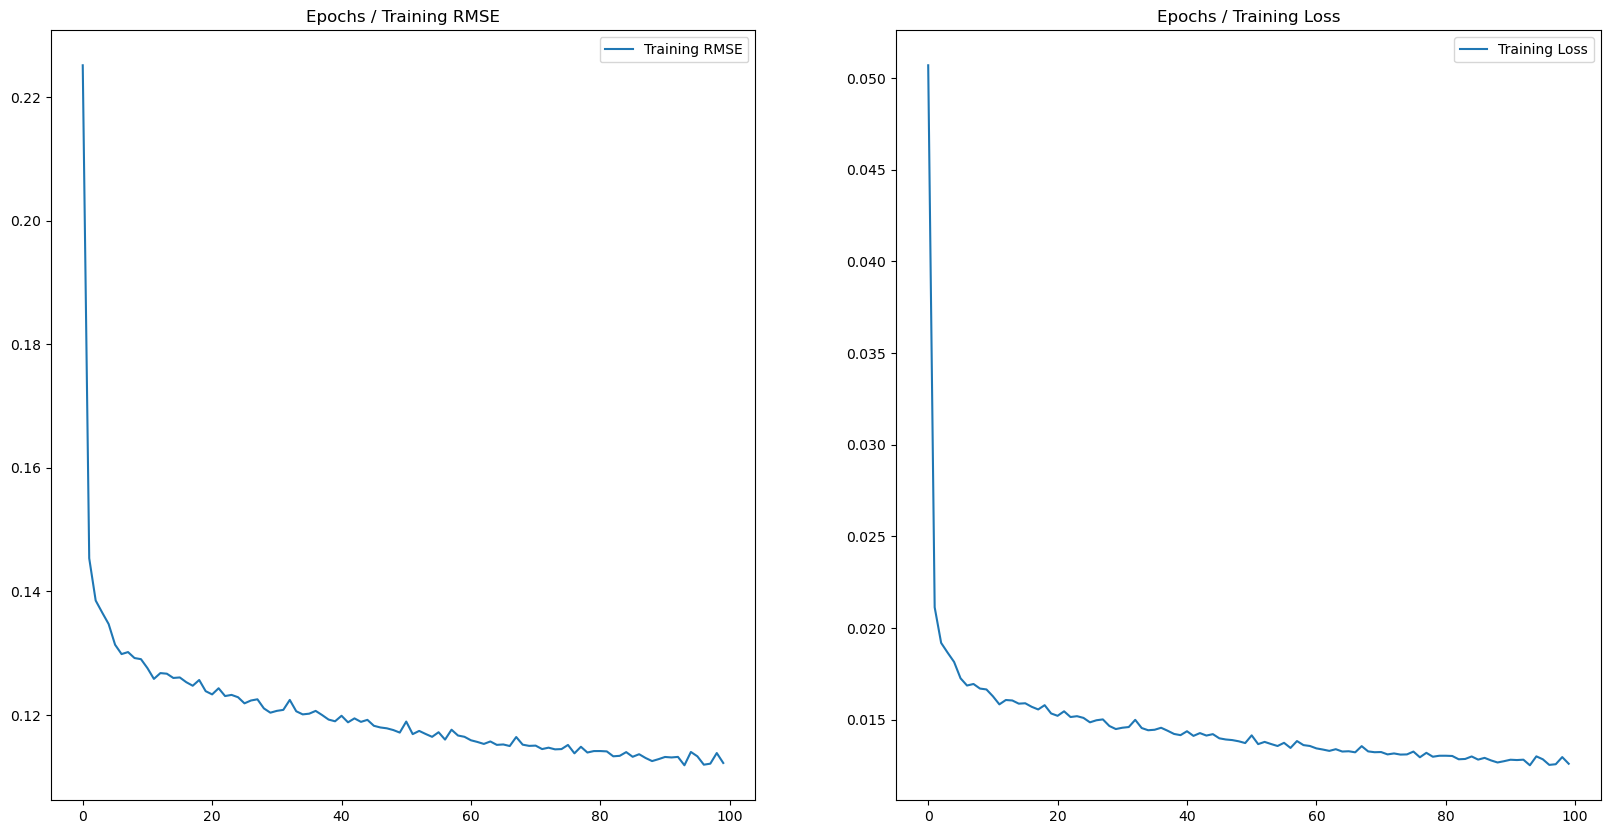

In [127]:
# Fit the model on the training data
history = mlp.fit(X_train, y_train, epochs=50, batch_size=168, verbose=1)
plot_model_rmse_and_loss(history)

549/549 [==============================] - 1s 1ms/step


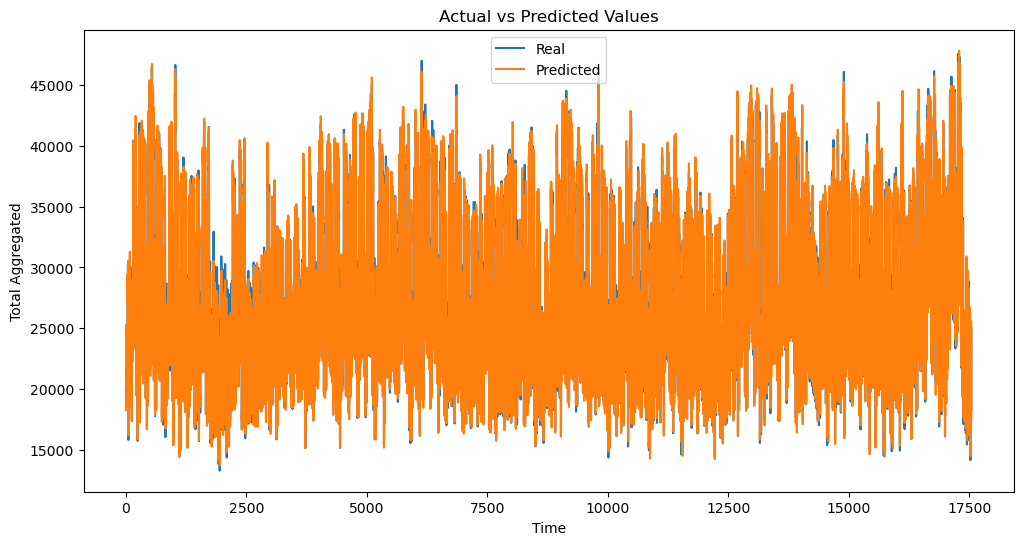

In [128]:
# Make predictions on the test data
y_pred = mlp.predict(X_test)

### Inverse transform the scaled test data and predictions
y_test_inv = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
y_true = []
for i in y_test_inv:
    y_true.append(float(i))
    
y_pred_inv = scaler.inverse_transform(y_pred)
#
## Plot the actual and predicted values
plot_preds_vs_actual(y_true, y_pred_inv)

In [129]:
res = pd.DataFrame()
res['y_true'] = y_true
res['y_pred'] = y_pred_inv

mse = sqrt(np.mean((res.y_pred - res.y_true)**2))
print('Mean Squared Error:', mse)

Mean Squared Error: 897.4606269792571


In [20]:
energies = ['biomass', 'hard_coal', 'oil', 'geothermal', 'other', 'solar', 'waste',
       'wind','total_aggregated', 'hydro_tot', 'gas_tot']

# WEEKEND

In [143]:
features = ['total_aggregated', 'saturday', 'sunday']
feature_array = data[features].values
window_size = 24


# Fit Scaler only on Training target values
target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train, 0].reshape(-1,1))

# Transfom on both Training and Test data
scaled_feature = target_scaler.transform(feature_array[:, 0].reshape(-1, 1))

scaled_array = np.copy(feature_array)
scaled_array[:, 0] = scaled_feature.flatten()

# Create a DataFrame from the observations
df = pd.DataFrame(scaled_array, columns=['total_aggregated', 'sat', 'sun'])


# Create 24 lags and store them as new columns in the DataFrame
for i in range(1, 25):
    df[f'lag_{i}'] = df['total_aggregated'].shift(i)

# Interpolate missing values
df = df.bfill()
# Define the number of train and test observations

# Separate the lags (features) and the observation (target)
X = df.drop('total_aggregated', axis=1)
y = df['total_aggregated']

# Separate the features into training and test sets
X_train = X[:n_train]
X_test = X[n_train:]

y_train, y_test = y[:n_train], y[n_train:]

In [144]:
# Define the model
mlp2 = tf.keras.models.Sequential([
    Dense(100, activation='relu', input_shape=(26,)),
    Dense(50, activation='relu'),
    #Dense(64, activation='relu'),
    Dense(1, activation='linear')
])
mlp2.compile(optimizer=optimizer, loss=loss, metrics = metric)

Epoch 1/100
209/209 [==============================] - 1s 2ms/step - loss: 0.0628 - root_mean_squared_error: 0.1941
Epoch 2/100
209/209 [==============================] - 0s 2ms/step - loss: 0.0219 - root_mean_squared_error: 0.1478
Epoch 3/100
209/209 [==============================] - 0s 2ms/step - loss: 0.0196 - root_mean_squared_error: 0.1398
Epoch 4/100
209/209 [==============================] - 0s 2ms/step - loss: 0.0185 - root_mean_squared_error: 0.1360
Epoch 5/100
209/209 [==============================] - 1s 2ms/step - loss: 0.0178 - root_mean_squared_error: 0.1334
Epoch 6/100
209/209 [==============================] - 1s 3ms/step - loss: 0.0172 - root_mean_squared_error: 0.1313
Epoch 7/100
209/209 [==============================] - 1s 3ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306
Epoch 8/100
209/209 [==============================] - 1s 3ms/step - loss: 0.0164 - root_mean_squared_error: 0.1282
Epoch 9/100
209/209 [==============================] - 0s 2ms/step - los

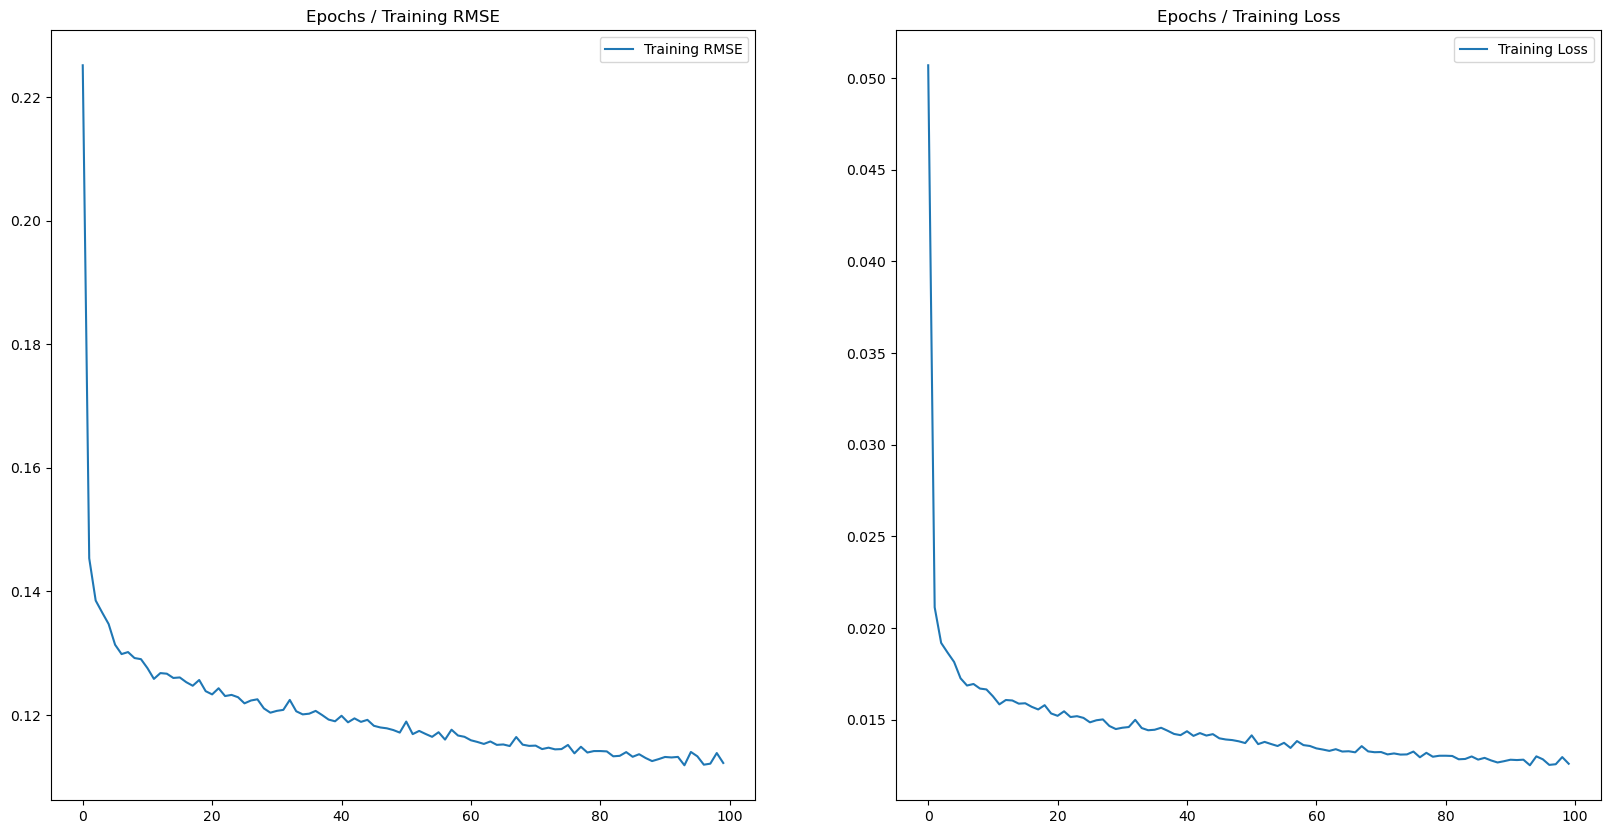

In [145]:
# Fit the model on the training data
history2 = mlp2.fit(X_train, y_train, epochs=50, batch_size=168, verbose=1)
plot_model_rmse_and_loss(history)

In [146]:
# Make predictions on the test data
y_pred2 = mlp2.predict(X_test)

## Inverse transform the scaled test data and predictions
#y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred2_inv = target_scaler.inverse_transform(y_pred2)

549/549 [==============================] - 1s 1ms/step


In [147]:
res['y_pred2'] = y_pred2_inv

mse2 = sqrt(np.mean((res.y_pred2 - res.y_true)**2))
print('Mean Squared Error:', mse2)

Mean Squared Error: 895.7852538073074


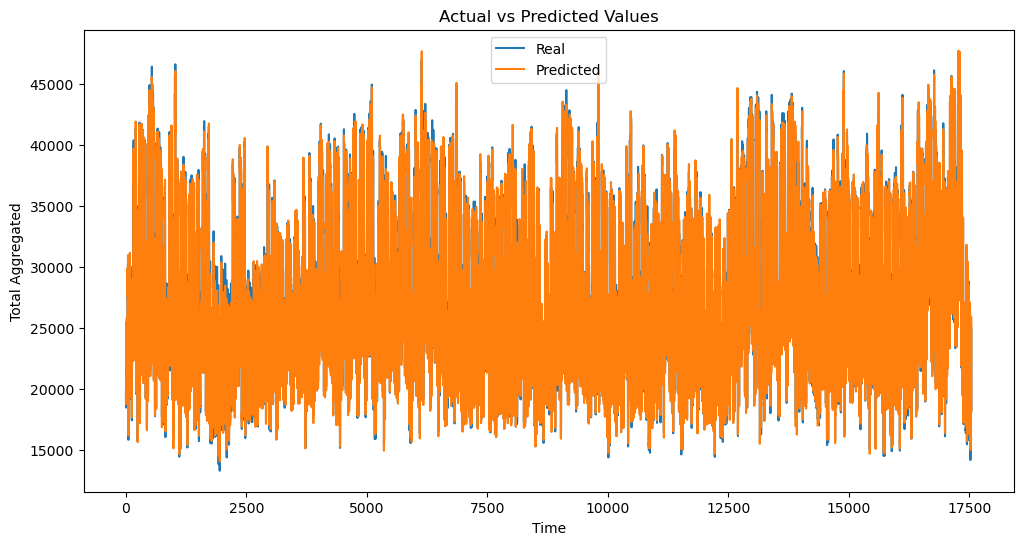

In [148]:
plot_preds_vs_actual(res.y_true, res.y_pred2)

# BUSINESS

In [149]:
features = ['total_aggregated', 'business hour']
feature_array = data[features].values

# Fit Scaler only on Training target values
target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train, 0].reshape(-1,1))

# Transfom on both Training and Test data
scaled_feature = target_scaler.transform(feature_array[:, 0].reshape(-1, 1))

scaled_array = np.copy(feature_array)
scaled_array[:, 0] = scaled_feature.flatten()

# Create a DataFrame from the observations
df = pd.DataFrame(scaled_array, columns=['total_aggregated', 'business hour'])


# Create 24 lags and store them as new columns in the DataFrame
for i in range(1, 25):
    df[f'lag_{i}'] = df['total_aggregated'].shift(i)

# Interpolate missing values
df = df.bfill()
# Define the number of train and test observations

# Separate the lags (features) and the observation (target)
X = df.drop('total_aggregated', axis=1)
y = df['total_aggregated']

# Separate the features into training and test sets
X_train = X[:n_train]
X_test = X[n_train:]

y_train, y_test = y[:n_train], y[n_train:]

In [150]:
# Define the model
mlp3 = tf.keras.models.Sequential([
    Dense(100, activation='relu', input_shape=(25,)),
    Dense(50, activation='relu'),
    #Dense(64, activation='relu'),
    Dense(1, activation='linear')
])
mlp3.compile(optimizer=optimizer, loss=loss, metrics = metric)

Epoch 1/100
209/209 [==============================] - 1s 1ms/step - loss: 0.0516 - root_mean_squared_error: 0.1789
Epoch 2/100
209/209 [==============================] - 0s 1ms/step - loss: 0.0208 - root_mean_squared_error: 0.1441
Epoch 3/100
209/209 [==============================] - 0s 2ms/step - loss: 0.0195 - root_mean_squared_error: 0.1397
Epoch 4/100
209/209 [==============================] - 0s 1ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345
Epoch 5/100
209/209 [==============================] - 0s 1ms/step - loss: 0.0178 - root_mean_squared_error: 0.1332
Epoch 6/100
209/209 [==============================] - 0s 1ms/step - loss: 0.0177 - root_mean_squared_error: 0.1329
Epoch 7/100
209/209 [==============================] - 0s 1ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312
Epoch 8/100
209/209 [==============================] - 0s 1ms/step - loss: 0.0168 - root_mean_squared_error: 0.1296
Epoch 9/100
209/209 [==============================] - 0s 1ms/step - los

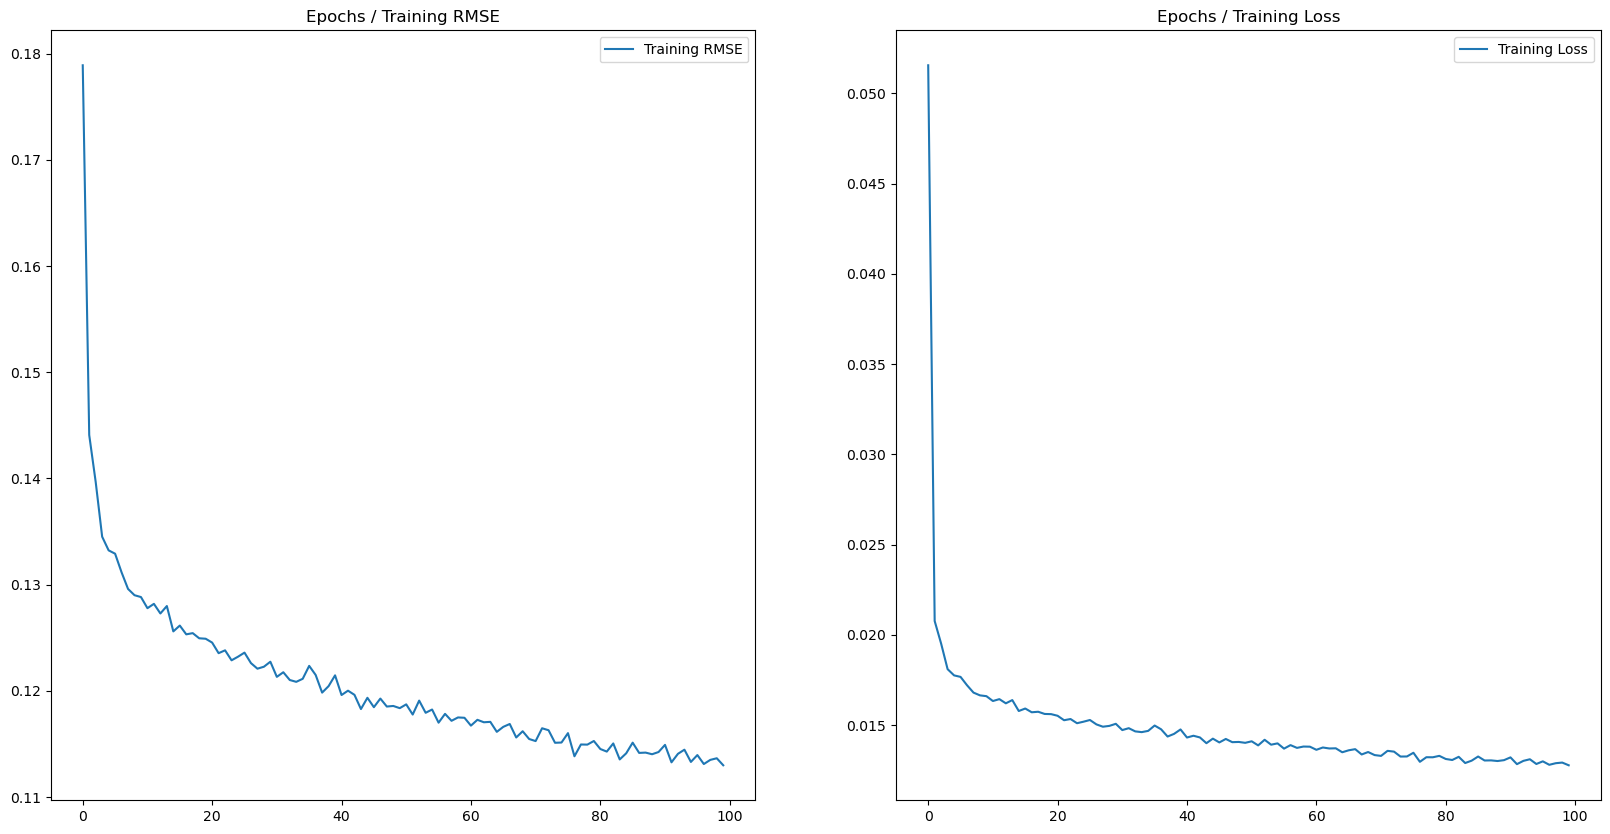

In [151]:
# Fit the model on the training data
history3 = mlp3.fit(X_train, y_train, epochs=100, batch_size=168, verbose=1)
plot_model_rmse_and_loss(history3)

In [152]:
# Make predictions on the test data
y_pred3 = mlp3.predict(X_test)

## Inverse transform the scaled test data and predictions
#y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred3_inv = target_scaler.inverse_transform(y_pred3)

549/549 [==============================] - 1s 2ms/step


In [153]:
res['y_pred3'] = y_pred3_inv

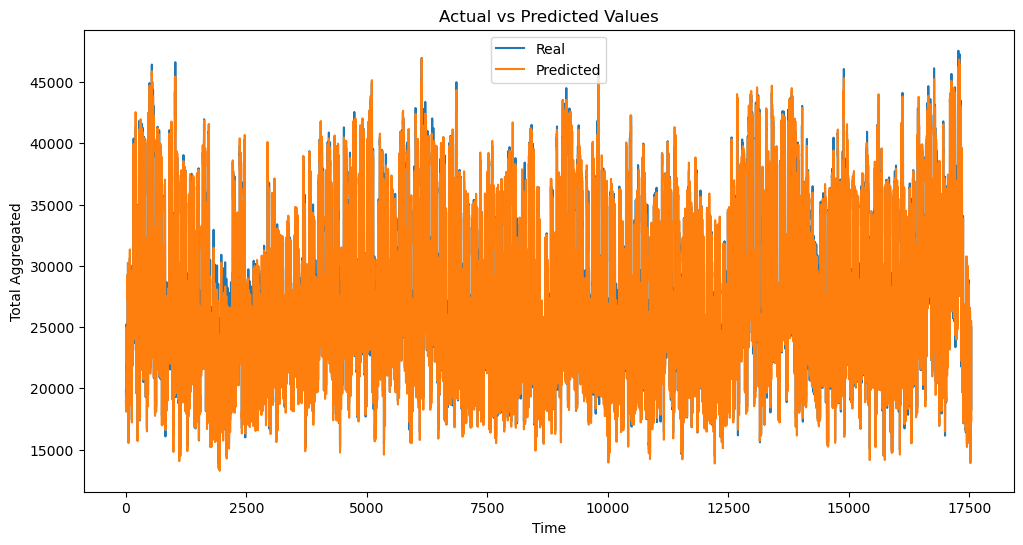

In [154]:
plot_preds_vs_actual(res.y_true, res.y_pred3)

In [155]:
mse1 = sqrt(np.mean((res.y_pred - res.y_true)**2))
print('Root Mean Squared Error just TS:', mse1)
mse2 = sqrt(np.mean((res.y_pred2 - res.y_true)**2))
print('Root Mean Squared Error WE dummies:', mse2)
mse3 = sqrt(np.mean((res.y_pred3 - res.y_true)**2))
print('Root Mean Squared Error BH dummy:', mse3)

Root Mean Squared Error just TS: 897.4606269792571
Root Mean Squared Error WE dummies: 895.7852538073074
Root Mean Squared Error BH dummy: 901.8943979670479
